In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils.reparam_module import ReparamModule

In [2]:
from utils import *
config = {
    'dataset': 'amazon-toys-noise-50',
    'model': 'MetaModel7',
}
sub_model = 'FMLP'
dataset = 'toy'

config = load_config(config)
dataset_list = prepare_datasets(config)
config['model']['sub_model'] = sub_model
model = prepare_model(config, dataset_list)
model._init_model(dataset_list[0])
device = model.device
state_dict_path = {
    'beauty': {
        'SASRec': 'saved/MetaModel7/amazon-beauty-noise-50/2024-02-01-00-51-08-316785.ckpt',
    },
    'sport': {
        'SASRec': 'saved/MetaModel7/amazon-sport-noise-50/2024-02-01-10-12-35-430957.ckpt',
    },
    'toy': {
        'SASRec': 'saved/MetaModel7/amazon-toys-noise-50/2024-01-31-23-58-49-529787.ckpt',
        'GRU4Rec': 'saved/MetaModel7/amazon-toys-noise-50/2024-02-01-13-08-11-946162.ckpt',
        'GNN': 'saved/MetaModel7/amazon-toys-noise-50/2024-02-01-15-33-58-403521.ckpt',
        'CL4SRec': 'saved/MetaModel7/amazon-toys-noise-50/2024-02-01-18-02-42-186590.ckpt',
        'FMLP': 'saved/MetaModel7/amazon-toys-fmlp/2024-02-04-23-11-22-982371.ckpt',
    },
    'yelp-small': {
        'SASRec': 'saved/MetaModel7/yelp-small-noise-50/2024-02-01-14-58-24-736826.ckpt',
    }
}
model.load_checkpoint(state_dict_path[dataset][sub_model])
model = model.to('cuda:' + str(model.device))
if sub_model == 'GNN':
    model.sub_model.query_encoder.norm_adj = model.sub_model.query_encoder.norm_adj.to('cuda:' + str(model.device))

In [3]:
loader = model.dataset_list[0].get_loader(shuffle=False)

In [4]:
loss_weight_list = []
logits_list = []
model.eval()
for batch in loader:
    query = model.sub_model.forward(batch, need_pooling=False)
    logits = model.meta_module(query)
    logits_list.append(logits.detach().cpu())
    weight = F.gumbel_softmax(logits, torch.clip(model.tau, min=1), dim=-1)[..., 0]
    mask = batch['user_id'] == 0
    if len(weight.shape) == 2:
        mask = mask.unsqueeze(-1)
    weight = weight.masked_fill(mask, 1)
    pad_mask = batch['item_id'] == 0
    weight = weight.masked_fill(pad_mask, 0)
    loss_weight_list.append(weight.detach().cpu())
loss_weight = torch.cat(loss_weight_list)
logits = torch.cat(logits_list)

In [5]:
torch.save(loss_weight, f'paper/loss_weight_{sub_model}_{dataset}.pth')
torch.save([logits, model.tau.item()], f'paper/logits_{sub_model}_{dataset}.pth')

# Analyze

In [6]:
sub_model_list = ['GRU4Rec', 'SASRec', 'GNN', 'CL4SRec', 'FMLP']
mask = (model.dataset_list[0].data[0] != 0).cpu() # select meaningful points to compare
flag = False
while(True):
    selected_idx = torch.randperm(mask.sum().item())[:25]
    data = []
    for model_name in sub_model_list:
        loss_weight = torch.load(f'paper/loss_weight_{model_name}_toy.pth')
        matrix = loss_weight[mask][selected_idx][:, :25]
        data.append(matrix)
        if matrix.max() > 0.8:
            flag = True
    if flag:
        break

/tmp/ipykernel_55158/2334706861.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


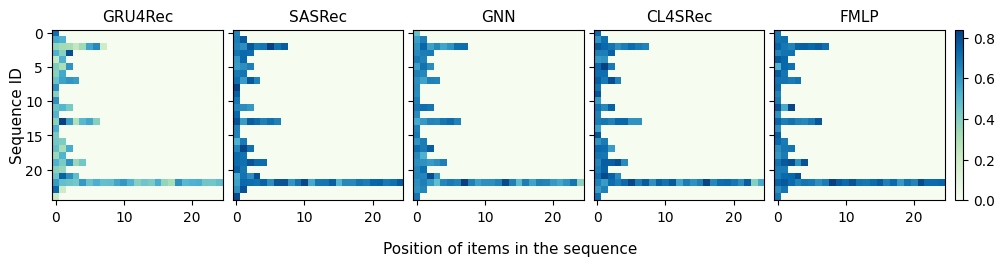

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# 创建画布和ImageGrid布局
fig = plt.figure(figsize=(10, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.1, cbar_mode='single')
# norm = matplotlib.colors.Normalize(vmin=0,vmax=0.8)

# 绘制热力图和设置标题
first_im = None
for idx, img in enumerate(data):
    # im = grid[idx].imshow(img, cmap='GnBu', norm=norm)
    im = grid[idx].imshow(img, cmap='GnBu')
    if first_im == None:
        first_im = im
    grid[idx].set_title(sub_model_list[idx], fontdict={'size': 11})

# 创建共享colorbar
cbar = grid.cbar_axes[0].colorbar(first_im)

fig.text(0.5, 0.27, 'Position of items in the sequence', ha='center', fontdict={'size': 11})
fig.text(0, 0.5, 'Sequence ID', va='center', rotation='vertical', fontdict={'size': 11})
# 调整子图布局
plt.tight_layout()

plt.savefig(f'figure/heat_map_all.pdf', dpi=600, bbox_inches = 'tight')
# 显示图形
plt.show()